![spreedsheet_finance](spreedsheet_finance.jpg)

Your project is centered around developing a reinforcement learning (RL) simulation for stock trading in Python. This initiative is spearheaded by Quantum Trading, a fictional but ambitious trading firm looking to leverage cutting-edge machine learning techniques to gain a competitive edge in the financial markets. Quantum Trading is a small but highly specialised team of financial analysts, data scientists, and software engineers who are passionate about transforming the way trading decisions are made.

In the fast-paced world of financial markets, staying ahead of the curve is crucial. Traditional trading strategies, while effective, often rely on historical data and predefined rules that may not adapt quickly to changing market conditions. Reinforcement learning, a subfield of machine learning where an agent learns to make decisions by interacting with an environment, offers a promising alternative. It allows the trading algorithms to learn and adapt in real-time, improving their performance as they gain more experience.

By engaging with this project, you will gain valuable insights into the dynamic world of algorithmic trading and enhance your skill set in data science, finance, and machine learning. Remember, the journey of learning and experimentation is as important as the results. Good luck, and may your trading algorithms be ever profitable!

## The Data
The provided data `AAPL.csv` contains historical prices for AAPL (the ticker symbol for Apple Inc) and you will be using this in your model. It has been loaded for you already in the sample code below and contains two columns, described below.

| Column | Description |
|--------|-------------|
|`Date`    | The date corresponding to the closing price              |
|`Close`   | The closing price of the security on the given date      |

_**Disclaimer: This project is for educational purposes only. It is not financial advice, and should not be understood or construed as, financial advice.**_

In [ ]:
# Make sure to run this cell to use gymnasium gym-anytrading stable-baselines3
!pip install gymnasium gym-anytrading stable-baselines3

In [2]:
# Import required packages
# Note that gym-anytrading is a gym environment specific for trading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Load the data provided
data = pd.read_csv("AAPL.csv", parse_dates=True, index_col='Date')

# Set window size (lookback window), start and end index of data
window_size = 10
start_index = window_size
end_index = len(data)

env = gym.make('stocks-v0', df=data, window_size=window_size, frame_bound=(start_index, end_index))
print("Observation Space:", env.observation_space)

Observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [3]:
# Create and train the PPO model
# 'MlpPolicy' is a standard feedforward neural network policy.
# verbose=1 will print out training progress.
model = PPO('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=10000)

In [4]:
# Evaluate
balance = 100000
initial_balance = balance
balance_history = [balance]
shares_held = 0
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Reset the environment
observation, info = env.reset(seed=48823)
terminated = False
truncated = False

buy_signals = []
sell_signals = []

trade_percent = 0.20 # Invest 20% of balance on a buy signal

while not terminated and not truncated:
    current_price = env.unwrapped.df['Close'].iloc[env.unwrapped._current_tick]

    action, _states = model.predict(observation, deterministic=True)

    if action == Actions.Buy.value:
        if balance > 0:
            action_stats[Actions.Buy] += 1
            trade_amount = balance * trade_percent
            shares_to_buy = trade_amount / current_price
            shares_held += shares_to_buy
            balance -= trade_amount
            buy_signals.append((env.unwrapped._current_tick, current_price))

    elif action == Actions.Sell.value:
        if shares_held > 0:
            action_stats[Actions.Sell] += 1
            sell_value = shares_held * current_price
            balance += sell_value
            shares_held = 0
            sell_signals.append((env.unwrapped._current_tick, current_price))

    observation, reward, terminated, truncated, info = env.step(action)

    new_price = env.unwrapped.df['Close'].iloc[env.unwrapped._current_tick]
    portfolio_value = balance + (shares_held * new_price)
    balance_history.append(portfolio_value)

if shares_held > 0:
    final_price = env.unwrapped.df['Close'].iloc[env.unwrapped._current_tick]
    final_value = shares_held * final_price
    balance += final_value
    shares_held = 0
    balance_history[-1] = balance # Update the last history entry
    print(f"\nSelling remaining shares at the end for ${final_price:.2f}")



Selling remaining shares at the end for $227.82


In [5]:
print(f"Initial Balance: ${initial_balance:,.2f}")
print(f"Final Portfolio Value: ${balance:,.2f}")
profit = balance - initial_balance
profit_percent = (profit / initial_balance) * 100
print(f"Profit: ${profit:,.2f} ({profit_percent:.2f}%)")
print(f"Total Buy Actions: {action_stats[Actions.Buy]}")
print(f"Total Sell Actions: {action_stats[Actions.Sell]}")

Initial Balance: $100,000.00
Final Portfolio Value: $3,961,377.50
Profit: $3,861,377.50 (3861.38%)
Total Buy Actions: 3763
Total Sell Actions: 0


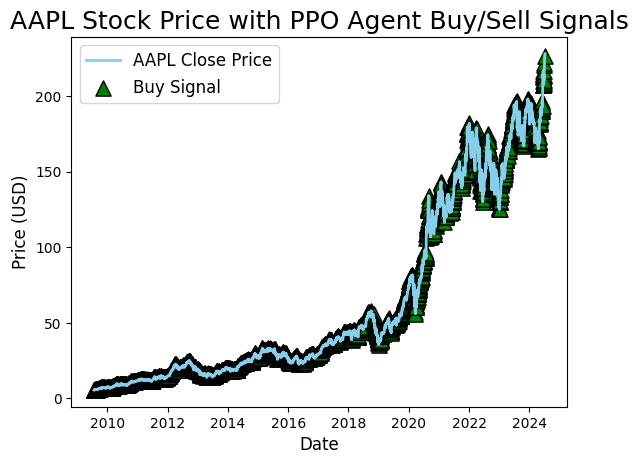

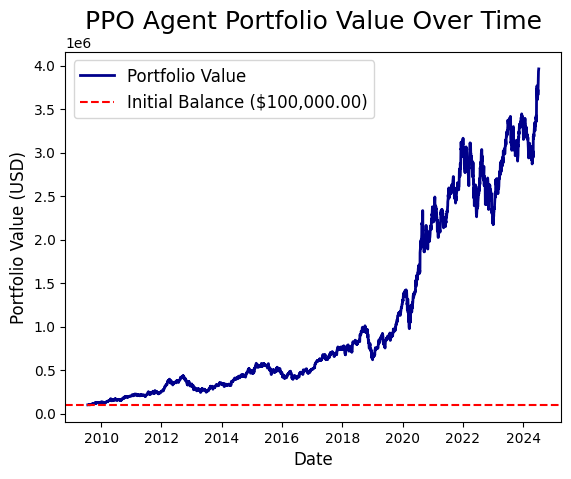

In [6]:
# Chart 1: Stock Price with Buy/Sell markers
fig, ax = plt.subplots()
ax.plot(data['Close'][start_index:end_index], label='AAPL Close Price', color='skyblue', linewidth=2)

if buy_signals:
    buy_indices = [signal[0] for signal in buy_signals]
    buy_prices = [signal[1] for signal in buy_signals]
    ax.scatter(data.index[buy_indices], buy_prices, marker='^', color='green', label='Buy Signal', s=120, edgecolors='black')

if sell_signals:
    sell_indices = [signal[0] for signal in sell_signals]
    sell_prices = [signal[1] for signal in sell_signals]
    ax.scatter(data.index[sell_indices], sell_prices, marker='v', color='red', label='Sell Signal', s=120, edgecolors='black')

ax.set_title('AAPL Stock Price with PPO Agent Buy/Sell Signals', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.legend(fontsize=12)
plt.show()

# Chart 2: Portfolio Value (Balance) Over Time
fig2, ax2 = plt.subplots()
trading_period_dates = data.index[start_index:end_index+1]
ax2.plot(trading_period_dates[:len(balance_history)], balance_history, label='Portfolio Value', color='darkblue', linewidth=2)
ax2.axhline(y=initial_balance, color='r', linestyle='--', label=f'Initial Balance (${initial_balance:,.2f})')

ax2.set_title('PPO Agent Portfolio Value Over Time', fontsize=18)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax2.legend(fontsize=12)
plt.show()